In [3]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timezone, timedelta
import time
import glob
import gzip
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
from helpers.charts import plot_line
import helpers.charts as charts

In [5]:
from helpers.preprocess_data import preprocess_data

In [6]:
DATA_FOLDER = 'data/leitos/'
UPDATED_DAYS = [1, 2, 7, 14, 60, 90]
MAIN_DAYS = 14

In [7]:
# # convert old files
# data_files = glob.glob(f'{DATA_FOLDER}data_*.json.gz')
# print(data_files)
# for f in data_files:
#     with gzip.open(f, 'r') as fin:
#         data = json.loads(fin.read().decode('utf-8'))
#         ts_run = data['ts_run']
#         hits = data['hits']['hits']
#         df = pd.json_normalize(hits)
#         df.columns = [x.replace('_source.', '') for x in df.columns.values]
#         df['ts_run'] = ts_run
#         print(f, ts_run)
#         df.to_csv(f.replace('json', 'csv'), compression='gzip', index=False, float_format='%.3f')

In [8]:
data_files = glob.glob(f'{DATA_FOLDER}data_*.csv.gz')
data_files.sort(reverse=False)
data_files

['data/leitos/data_2021-02-23.csv.gz',
 'data/leitos/data_2021-02-24.csv.gz',
 'data/leitos/data_2021-02-25.csv.gz',
 'data/leitos/data_2021-02-26.csv.gz',
 'data/leitos/data_2021-02-27.csv.gz',
 'data/leitos/data_2021-02-28.csv.gz',
 'data/leitos/data_2021-03-01.csv.gz',
 'data/leitos/data_2021-03-02.csv.gz',
 'data/leitos/data_2021-03-03.csv.gz',
 'data/leitos/data_2021-03-04.csv.gz',
 'data/leitos/data_2021-03-05.csv.gz',
 'data/leitos/data_2021-03-06.csv.gz',
 'data/leitos/data_2021-03-07.csv.gz',
 'data/leitos/data_2021-03-08.csv.gz',
 'data/leitos/data_2021-03-09.csv.gz',
 'data/leitos/data_2021-03-10.csv.gz',
 'data/leitos/data_2021-03-11.csv.gz',
 'data/leitos/data_2021-03-12.csv.gz',
 'data/leitos/data_2021-03-13.csv.gz',
 'data/leitos/data_2021-03-14.csv.gz',
 'data/leitos/data_2021-03-15.csv.gz',
 'data/leitos/data_2021-03-16.csv.gz',
 'data/leitos/data_2021-03-17.csv.gz',
 'data/leitos/data_2021-03-18.csv.gz',
 'data/leitos/data_2021-03-19.csv.gz',
 'data/leitos/data_2021-0

In [9]:
frames = []
for f in data_files[:]:
    df = pd.read_csv(f)
    ts_run = pd.to_datetime(df.iloc[0]['ts_run'])
    print(ts_run, f)
    df_hb = preprocess_data(df, UPDATED_DAYS, ts_run)
    frames.append(df_hb)

2021-02-23 16:00:11.117292+00:00 data/leitos/data_2021-02-23.csv.gz
2021-02-24 16:00:25.550239+00:00 data/leitos/data_2021-02-24.csv.gz
2021-02-25 16:00:49.383490+00:00 data/leitos/data_2021-02-25.csv.gz
2021-02-26 16:00:42.144434+00:00 data/leitos/data_2021-02-26.csv.gz
2021-02-27 16:00:29.121510+00:00 data/leitos/data_2021-02-27.csv.gz
2021-02-28 16:00:40.846752+00:00 data/leitos/data_2021-02-28.csv.gz
2021-03-01 16:01:02.122943+00:00 data/leitos/data_2021-03-01.csv.gz
2021-03-02 16:01:02.906894+00:00 data/leitos/data_2021-03-02.csv.gz
2021-03-03 16:01:16.597122+00:00 data/leitos/data_2021-03-03.csv.gz
2021-03-04 16:02:20.806788+00:00 data/leitos/data_2021-03-04.csv.gz
2021-03-05 19:36:34.482084+00:00 data/leitos/data_2021-03-05.csv.gz
2021-03-06 16:00:38.348330+00:00 data/leitos/data_2021-03-06.csv.gz
2021-03-07 16:00:30.707795+00:00 data/leitos/data_2021-03-07.csv.gz
2021-03-08 18:16:48.451248+00:00 data/leitos/data_2021-03-08.csv.gz
2021-03-09 16:01:06.965921+00:00 data/leitos/dat

In [10]:
metrics_series = []
for df_hb in frames:
    ts_run = pd.to_datetime(df_hb.iloc[0]['ts_run'])
    pct_outdated = 1 - (len(df_hb[df_hb[f'updated_{str(MAIN_DAYS)}d'] == True]) / len(df))
    
    df_uti = df_hb[(df_hb.has_uti_proxy == True) & (df_hb.deactivated_proxy == False)]
    totalOcupUti = df_uti['totalOcupUti'].sum()
    totalOfertaUti = df_uti['totalOfertaUti'].sum()
    ocupHospUti = df_uti['ocupHospUti'].sum()
    ofertaHospUti = df_uti['ofertaHospUti'].sum()
    ocupSRAGUti = df_uti['ocupSRAGUti'].sum()
    ofertaSRAGUti = df_uti['ofertaSRAGUti'].sum()
    pct_icu_occupied = totalOcupUti / totalOfertaUti
    pct_icu_hosp_occupied = ocupHospUti / ofertaHospUti
    pct_icu_covid_occupied = ocupSRAGUti / ofertaSRAGUti
    metrics_series.append({'ts_run': ts_run, f'pct_not_updated_{str(MAIN_DAYS)}d': pct_outdated,
                           'pct_icu_occupied': pct_icu_occupied,
                           'pct_icu_hosp_occupied': pct_icu_hosp_occupied,
                           'pct_icu_covid_occupied': pct_icu_covid_occupied,
                           'totalOcupUti': totalOcupUti,
                           'totalOfertaUti': totalOfertaUti,
                           'ocupHospUti': ocupHospUti,
                           'ofertaHospUti': ofertaHospUti,
                           'ocupSRAGUti': ocupSRAGUti,
                           'ofertaSRAGUti': ofertaSRAGUti,
                          })
    
metrics_series = pd.DataFrame(metrics_series)
metrics_series['ts_run'] = pd.to_datetime(metrics_series['ts_run'])
metrics_series.set_index('ts_run', inplace=True)

<AxesSubplot:xlabel='ts_run'>

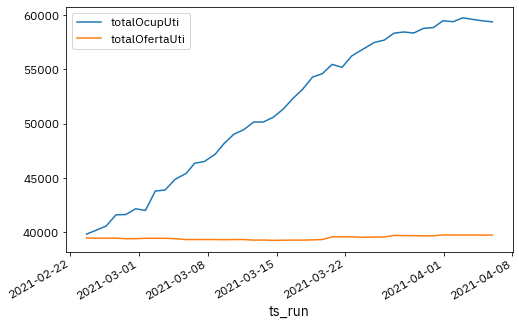

In [11]:
metrics_series[['totalOcupUti', 'totalOfertaUti']].plot.line(figsize=(8,5))

<AxesSubplot:xlabel='ts_run'>

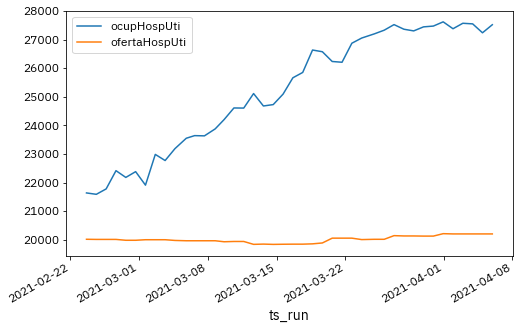

In [12]:
metrics_series[['ocupHospUti', 'ofertaHospUti']].plot.line(figsize=(8,5))

<AxesSubplot:xlabel='ts_run'>

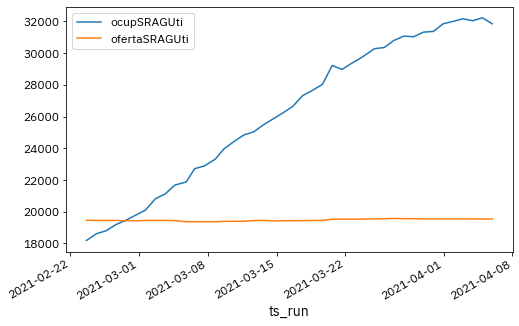

In [13]:
metrics_series[['ocupSRAGUti', 'ofertaSRAGUti']].plot.line(figsize=(8,5))

<AxesSubplot:xlabel='ts_run'>

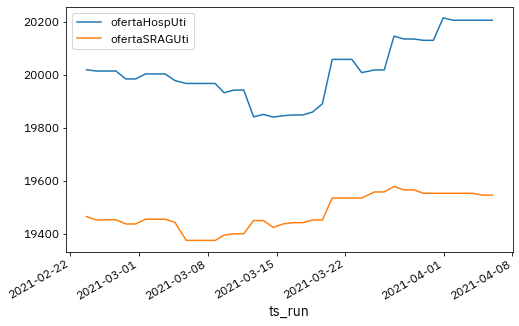

In [14]:
metrics_series[['ofertaHospUti', 'ofertaSRAGUti']].plot.line(figsize=(8,5))

## Gráficos

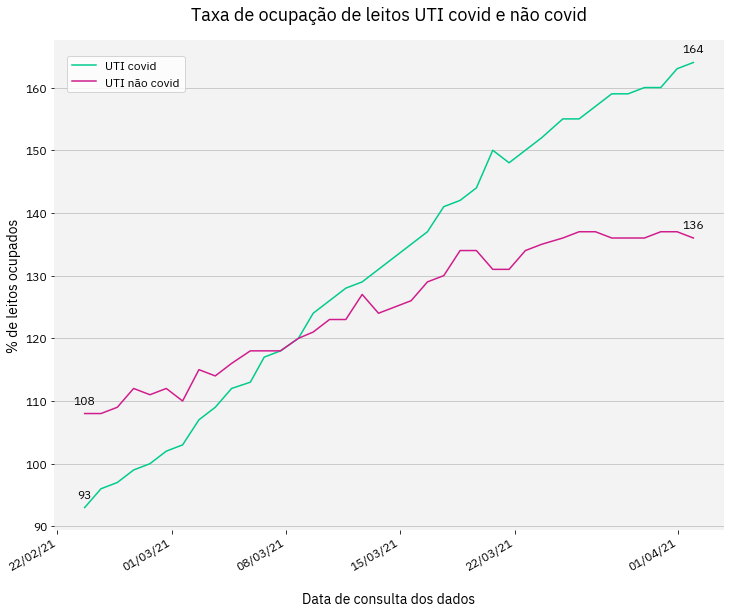

In [21]:
cols = ['pct_icu_covid_occupied', 'pct_icu_hosp_occupied']
legend = ['UTI covid', 'UTI não covid']
df_tmp = metrics_series[cols]

df_tmp = df_tmp[df_tmp.index.to_series() < '2021-04-02']

ax = plot_line(df_tmp, round_pct=True,
          color=[charts.OK_COLOR_SCALE_DIVERGING_COLORS[0], charts.OK_COLOR_SCALE_DIVERGING_COLORS[-1]],
          xlabel='Data de consulta dos dados',
          ylabel='% de leitos ocupados',
          title='Taxa de ocupação de leitos UTI covid e não covid',
          show_legend=True, legend=legend, 
          legend_bbox=(0.01, 0.98), legend_pos='upper left',
          date_string='%d/%m/%y',
          grid=True,
          figsize=(12,10),
          annotate=True, annotate_rows=[0, -1],
          date_col='ts_run',
          file_name='taxa_ocupacao_tempo',
         )